# TSFRESH Human Activity Recognition Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

import logging

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This mo

In [2]:
# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

## Load and visualize data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Furthermore, each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying)

For more information, or to fetch dataset, go to https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [3]:
# fetch dataset from uci
download_har_dataset()

In [4]:
df = load_har_dataset()
df.head()
df.shape

(7352, 128)

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


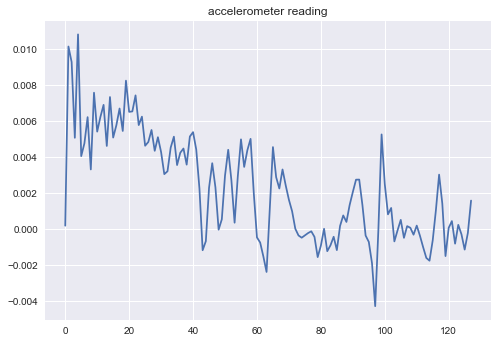

In [5]:
plt.title('accelerometer reading')
plt.plot(df.ix[0,:])
plt.show()

## Extract Features

In [6]:
extraction_settings = ComprehensiveFCParameters()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

In [7]:
# transpose since tsfresh reads times series data column-wise, not row-wise
df_t = df.copy().transpose()
df_t.shape

(128, 7352)

In [8]:
# rearrange sensor readings column-wise, not row-wise

master_df = pd.DataFrame(df_t[0])
master_df['id'] = 0

# grab first 500 readings to save time
for i in range(1, 500):
    temp_df = pd.DataFrame(df_t[i])
    temp_df['id'] = i
    master_df = pd.DataFrame(np.vstack([master_df, temp_df]))
print(master_df.shape)
master_df.head()


(64000, 2)


,0,1
0,0.000181,0.0
1,0.010139,0.0
2,0.009276,0.0
3,0.005066,0.0
4,0.010810,0.0


In [9]:
%time X = extract_features(master_df, column_id=1, default_fc_parameters=extraction_settings);

Feature Extraction: 100%|██████████| 1/1 [00:40<00:00, 40.53s/it]

CPU times: user 49 ms, sys: 49.8 ms, total: 98.8 ms
Wall time: 40.6 s


In [10]:
# in total we have transformed the sensor data into 222 features
X.shape

(500, 222)

In [11]:
X.columns

Index([u'0__approximate_entropy__m_2__r_0.7',
       u'0__approximate_entropy__m_2__r_0.5',
       u'0__approximate_entropy__m_2__r_0.3',
               u'0__value_count__value_-inf',
       u'0__approximate_entropy__m_2__r_0.1',
                    u'0__standard_deviation',
       u'0__approximate_entropy__m_2__r_0.9',
                     u'0__has_duplicate_min',
             u'0__first_location_of_maximum',
          u'0__mean_second_derivate_central',
       ...
              u'0__fft_coefficient__coeff_0',
              u'0__fft_coefficient__coeff_1',
              u'0__fft_coefficient__coeff_2',
              u'0__fft_coefficient__coeff_3',
              u'0__fft_coefficient__coeff_4',
              u'0__fft_coefficient__coeff_5',
              u'0__fft_coefficient__coeff_6',
              u'0__fft_coefficient__coeff_7',
              u'0__fft_coefficient__coeff_8',
              u'0__fft_coefficient__coeff_9'],
      dtype='object', length=222)

## Train and evaluate classifier

In [12]:
y = load_har_classes()[:500]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [14]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       1.00      0.89      0.94        19
          2       0.83      1.00      0.91        15
          3       1.00      0.83      0.91        12
          4       0.35      0.33      0.34        18
          5       0.56      0.41      0.47        22
          6       0.36      0.57      0.44        14

avg / total       0.67      0.65      0.65       100



# Multiclass feature selection

In total our feature matrix contains 222 features. 
We can try to select a subset of features with the select_features method of tsfresh. 

However it only works for binary classification or regression tasks. 

For a 6 label multi classification we split the selection problem into 6 binary one-versus all classification problems. For each of them we can do a binary classification feature selection:

In [15]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 65/222
Number of relevant features for class 4: 64/222
Number of relevant features for class 6: 54/222
Number of relevant features for class 1: 66/222
Number of relevant features for class 3: 77/222
Number of relevant features for class 2: 61/222


In [16]:
len(relevant_features)

96

so, we reduced the number of used features from 222 to 98

In [17]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       1.00      0.89      0.94        19
          2       0.83      1.00      0.91        15
          3       1.00      0.83      0.91        12
          4       0.46      0.33      0.39        18
          5       0.41      0.41      0.41        22
          6       0.30      0.43      0.35        14

avg / total       0.65      0.63      0.63       100



Unfortunately, the quality of the predictor worsen a little bit

## Compare against naive classification accuracy
By extracting using time-series features (as opposed to using raw data points), we can meaningfully increase classification accuracy.

In [18]:
X_1 = df.ix[:499,:]
X_1.shape

(500, 128)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

In [20]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.55      0.52      0.53        23
          2       0.50      0.54      0.52        13
          3       0.64      0.56      0.60        16
          4       0.22      0.42      0.29        12
          5       0.57      0.47      0.52        17
          6       0.46      0.32      0.37        19

avg / total       0.50      0.47      0.48       100



So, both our unfiltered and filtered feature based classificators are able to beat the model on the raw time series values 